In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
import pandas as pd
from sklearn.model_selection import train_test_split

In [3]:
jobs = pd.read_csv("ds.csv")

Extracting most used Tech in DS jobs and making new columns based on presence in job description:

In [4]:
# Extracting Tech form job DESCRIPTION and making new columns based on that:
def check_technology_presence(description, technology):
    return 1 if technology in description.lower() else 0

# Create individual columns for each technology
jobs['Python'] = jobs['Job Description'].apply(lambda x: check_technology_presence(x, 'python'))
jobs['R'] = jobs['Job Description'].apply(lambda x: check_technology_presence(x, ' r '))
jobs['SAS'] = jobs['Job Description'].apply(lambda x: check_technology_presence(x, 'sas'))
jobs['SQL'] = jobs['Job Description'].apply(lambda x: check_technology_presence(x, 'sql'))
jobs['Excel'] = jobs['Job Description'].apply(lambda x: check_technology_presence(x, 'excel'))
jobs['Power BI'] = jobs['Job Description'].apply(lambda x: check_technology_presence(x, 'powerbi') or check_technology_presence(x, 'power bi') or check_technology_presence(x, 'power-bi'))
jobs['Tableau'] = jobs['Job Description'].apply(lambda x: check_technology_presence(x, 'tableau'))
jobs['Software Tech'] = jobs['Job Description'].apply(lambda x: check_technology_presence(x, 'java') or check_technology_presence(x, 'c++')
                                                       or check_technology_presence(x, 'c#') or check_technology_presence(x, ' c '))

In [5]:
jobs['Software Tech'].value_counts()

Software Tech
0    1977
1     711
Name: count, dtype: int64

Making more General job titles columns to reduce count for analysis and model(later)

In [6]:
jobs['Job Title'].unique()

array(['Data Analyst', 'Data Scientist', 'Quantitative Researcher', ...,
       'Senior Data Engineer (Data ELT/ETL Engineer)',
       'Security Analytics Data Engineer',
       'Patient Safety Physician or Safety Scientist - UK, Europe or the US'],
      dtype=object)

In [7]:
# Modify the function to categorize job titles with the new insights
def refined_categorize_title(title):
    title = title.lower()  # Convert to lowercase for consistent comparison
    if 'analytic' in title or 'analysis' in title or 'data analyst' in title:
        return 'Analytics'
    elif 'business intelligence' in title:
        return 'BI'
    elif 'science' in title or 'scientist' in title:
        return 'Data Science'
    elif 'machine learning' in title or 'ml' in title or 'ai' in title:
        return 'ML/AI'
    elif 'senior' in title or 'sr.' in title:
        return 'Senior Jobs'
    elif 'data engineer' in title:
        return 'Data Engineer'
    elif 'product analyst' in title or 'product analysis' in title:
        return 'Product Analyst'
    elif 'quantitative' in title:
        return 'Quantitative Job'
    else:
        return 'Other'

# Apply the modified function to the 'Job Title' column to create the 'General_Title' column
jobs['General_Title'] = jobs['Job Title'].apply(refined_categorize_title)

# Check the distribution of the new column
jobs['General_Title'].value_counts()

General_Title
Data Science        1422
Analytics            648
Data Engineer        304
ML/AI                 76
Senior Jobs           75
BI                    64
Other                 57
Quantitative Job      42
Name: count, dtype: int64

In [8]:
# Filter out the job titles that are categorized as "Others"
other_titles = jobs[jobs['General_Title'] == 'Other']['Job Title']

# Get the most frequent job titles in the "Others" category
frequent_other_titles = other_titles.value_counts().head(20)  # Displaying top 20 for brevity
frequent_other_titles

Job Title
Data Modeler                                       6
Data Architect II                                  3
Data Architect / Engineer                          2
Data Architect                                     2
Big Data Consultant                                2
Intern- Martech & Data Consulting                  1
Spice Modeling Engineer                            1
Big Data Administrator/Developer                   1
Staff Software Engineer - Data Platform            1
Community Data Manager, Single-Cell Biology        1
SystemC Modeling Engineer                          1
Investigational Computational Biologist            1
Head of Data                                       1
Data Crawler Engineer                              1
Graphics (GPU) Performance Modeling Engineer       1
CPU Performance –Sr Principal Modeling Engineer    1
Data Specialist                                    1
Enterprise Cloud Data Architect                    1
SOC Architecture Modeling Engineer  

Creating salary categories based on the mean salary

In [9]:
# Create a new "Salary_Range_int" column based on the 'mean_salary' column
conditions = [
    jobs['mean_salary'] < 70,
    (jobs['mean_salary'] >= 70) & (jobs['mean_salary'] < 90),
    (jobs['mean_salary'] >= 90) & (jobs['mean_salary'] < 120),
    (jobs['mean_salary'] >= 120) & (jobs['mean_salary'] < 150),
    jobs['mean_salary'] >= 150
]

# Assigning the numerical categories from 0 to 4 based on the conditions
choices = [0, 1, 2, 3, 4]
jobs["Salary_Range_int"] = np.select(conditions, choices)

In [10]:
jobs['Salary_Range_int'].value_counts()

Salary_Range_int
3    704
2    616
0    549
4    410
1    409
Name: count, dtype: int64

In [11]:
jobs["Salary_Range_int"].head()

0    3
1    3
2    3
3    3
4    3
Name: Salary_Range_int, dtype: int32

Grouping Sectors into more general categories 

In [12]:
# Define the logical groupings for the sectors again
sector_groupings = {
    "Information Technology": "Information Technology",
    "Telecommunications": "Information Technology",
    
    "Insurance": "Financial & Legal Services",
    "Finance": "Financial & Legal Services",
    "Accounting & Legal": "Financial & Legal Services",
    "Real Estate": "Financial & Legal Services",
    
    "Business Services": "Consumer Services & Retail",
    "Restaurants, Bars & Food Services": "Consumer Services & Retail",
    "Retail": "Consumer Services & Retail",
    "Consumer Services": "Consumer Services & Retail",
    
    "Health Care": "Health & Pharmaceuticals",
    "Biotech & Pharmaceuticals": "Health & Pharmaceuticals",
    
    "Oil, Gas, Energy & Utilities": "Energy & Mining",
    "Mining & Metals": "Energy & Mining",
    
    "Government": "Public & Non-Profit",
    "Non-Profit": "Public & Non-Profit",
    "Education": "Public & Non-Profit",
    
    "Manufacturing": "Manufacturing & Construction",
    "Aerospace & Defense": "Manufacturing & Construction",
    "Construction, Repair & Maintenance": "Manufacturing & Construction",
    
    "Agriculture & Forestry": "Agriculture",
    
    
    "Entertainment & Media": "Entertainment, Arts & Tourism",
    "Travel & Tourism": "Entertainment, Arts & Tourism",
    "Media": "Entertainment & Media",
    
    "Transportation & Logistics": "Transportation & Logistics",
    
    "Unknown": "Others"
}

# Map the sectors to their respective groups
jobs['Sector_Grouped'] = jobs['Sector'].map(sector_groupings)

# Display the first few rows of the dataframe to verify the changes
jobs['Sector_Grouped'].unique()



array(['Information Technology', 'Financial & Legal Services', nan,
       'Consumer Services & Retail', 'Entertainment & Media',
       'Public & Non-Profit', 'Health & Pharmaceuticals',
       'Energy & Mining', 'Manufacturing & Construction', 'Agriculture',
       'Entertainment, Arts & Tourism', 'Transportation & Logistics'],
      dtype=object)

Converting the newly created general sectors into integers to be suitable for the model

In [13]:
# Dropping rows with 'Unknown' in Sector_Grouped
jobs = jobs[jobs['Sector_Grouped'] != 'Unknown']

# Mapping the grouped sectors to integers
sector_to_int_mapping = {
    "Technology & Media": 0,
    "Financial & Legal Services": 1,
    "Consumer Services & Retail": 2,
    "Health & Pharmaceuticals": 3,
    "Energy & Utilities": 4,
    "Public & Non-Profit": 5,
    "Manufacturing & Construction": 6,
    "Agriculture, Forestry & Mining": 7,
    "Entertainment, Arts & Tourism": 8,
    "Transportation & Logistics": 9
}

jobs['Sector_Int'] = jobs['Sector_Grouped'].map(sector_to_int_mapping)

# Display the unique values for verification
jobs['Sector_Int'].unique()

#Dropping Sector_Grouped column.
jobs.drop(columns=['Sector_Grouped','Sector'],inplace=True)

Converting the revene groups into int to be suitable for the model

In [14]:
# Mapping for the 'Revenue' column
revenue_mapping = {
    'Unknown / Non-Applicable': -1,
    'Unknown': -1,
    'Less than $1 million (USD)': 0,
    '$1 to $5 million (USD)': 1,
    '$5 to $10 million (USD)': 2,
    '$10 to $25 million (USD)': 3,
    '$25 to $50 million (USD)': 4,
    '$50 to $100 million (USD)': 5,
    '$100 to $500 million (USD)': 6,
    '$500 million to $1 billion (USD)': 7,
    '$1 to $2 billion (USD)': 8,
    '$2 to $5 billion (USD)': 9,
    '$5 to $10 billion (USD)': 10,
    '$10+ billion (USD)': 11
}

# Replace the values in the 'Revenue' column using the mapping
jobs['Revenue_Int'] = jobs['Revenue'].map(revenue_mapping)

# Verify the transformation
jobs['Revenue_Int'].unique()

array([-1.,  6.,  7., 11.,  1., nan,  4.,  8.,  9., 10.,  3.,  2.,  0.,
        5.])

In [15]:
jobs.head(1)

,...1,index,Job Title,Job Description,Rating,Company Name,Location,Headquarters,Size,Founded,...,SAS,SQL,Excel,Power BI,Tableau,Software Tech,General_Title,Salary_Range_int,Sector_Int,Revenue_Int
0,3,3,Data Analyst,Sapphire Digital seeks a dynamic and driven mi...,3.4,Sapphire Digital\r\n3.4,"Lyndhurst, NJ","Lyndhurst, NJ",201 to 500 employees,2019,...,1,1,1,1,0,0,Analytics,3,NaN,-1.0


In [16]:
# Dropping irrelevant columns
jobs.drop(columns=['Revenue','Salary_cat','Job Description','Job Title' ,'Company Name', 'Salary_Estimate', 'Competitors','mean_salary', '...1', 'index','Headquarters',
'Type of ownership','Industry','Location','Salary_cat','Easy Apply'], inplace=True)

# Replace -1 and '-1' (which seem to be placeholders for missing data) with NaN for better handling
jobs.replace([-1, '-1'], [None, None], inplace=True)

# Checking for missing values
missing_percentage = jobs.isna().mean() * 100

missing_percentage


Rating               9.858631
Size                 5.543155
Founded             23.028274
degree               0.000000
State                0.000000
Python               0.000000
R                    0.000000
SAS                  0.000000
SQL                  0.000000
Excel                0.000000
Power BI             0.000000
Tableau              0.000000
Software Tech        0.000000
General_Title        0.000000
Salary_Range_int     0.000000
Sector_Int          41.517857
Revenue_Int         33.705357
dtype: float64

In [17]:
# Filling numerical columns with mean
jobs['Rating'].fillna(jobs['Rating'].mean(), inplace=True)
jobs['Founded'].fillna(jobs['Founded'].mean(), inplace=True)


In [18]:
# Filling categorical columns with 'Unknown'
cols_fill_unknown = ['Size','Sector_Int']
for col in cols_fill_unknown:
    jobs[col].fillna('Unknown', inplace=True)

missing_percentage = jobs.isna().mean() * 100

missing_percentage


C:\Users\ahmed\AppData\Local\Temp\ipykernel_23500\352597326.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Unknown' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  jobs[col].fillna('Unknown', inplace=True)


Rating               0.000000
Size                 0.000000
Founded              0.000000
degree               0.000000
State                0.000000
Python               0.000000
R                    0.000000
SAS                  0.000000
SQL                  0.000000
Excel                0.000000
Power BI             0.000000
Tableau              0.000000
Software Tech        0.000000
General_Title        0.000000
Salary_Range_int     0.000000
Sector_Int           0.000000
Revenue_Int         33.705357
dtype: float64

Sector_Int still are the character: 'Unkown'.
taking the mean and rounding it.

In [19]:
# Compute the mean excluding the "Unknown" values and round it
rounded_mean = round(jobs[jobs['Sector_Int'] != 'Unknown']['Sector_Int'].astype(float).mean())

# Replace "Unknown" values with the rounded mean
jobs['Sector_Int'].replace('Unknown', rounded_mean, inplace=True)


In [20]:
# Checking unique values for categorical columns

unique_values = {}
categorical_columns = ['Size', 'degree', 'State']

for col in categorical_columns:
    unique_values[col] = jobs[col].nunique()

unique_values

{'Size': 8, 'degree': 3, 'State': 10}

In [21]:
# Checking unique values for categorical columns

unique_values = {}
categorical_columns = ['Size', 'degree', 'State']

for col in categorical_columns:
    unique_values[col] = jobs[col].nunique()

unique_values

{'Size': 8, 'degree': 3, 'State': 10}

In [22]:
jobs.head()

,Rating,Size,Founded,degree,State,Python,R,SAS,SQL,Excel,Power BI,Tableau,Software Tech,General_Title,Salary_Range_int,Sector_Int,Revenue_Int
0,3.400000,201 to 500 employees,2019.000000,BS,NJ,1,0,1,1,1,1,0,0,Analytics,3,3.0,None
1,2.900000,201 to 500 employees,1985.000000,BS,NY,1,0,1,1,0,0,0,0,Data Science,3,1.0,None
2,4.400000,51 to 200 employees,1993.000000,MS,NY,1,0,0,0,1,0,0,1,Quantitative Job,3,1.0,None
3,3.755592,1 to 50 employees,1967.733688,MS,NY,0,0,0,0,0,0,0,0,Quantitative Job,3,3.0,None
4,5.000000,1 to 50 employees,2018.000000,MS,NY,1,0,0,0,0,0,0,0,Data Science,3,3.0,None


In [23]:
# One-hot encoding the categorical variables
jobs_encoded = pd.get_dummies(jobs, columns=['degree', 'State','General_Title','Size']) * 1

#jobs_encoded = jobs_encoded * 1  # This converts True/False to 1/0. Only needed in VS Code not sure why. 

Converting all numerical values to the same type for the model

In [24]:
jobs_encoded = jobs_encoded.astype('float32')

In [25]:
# Separating features and target variable
X = jobs_encoded.drop(columns=['Salary_Range_int','Revenue_Int','Founded']).copy()
y = jobs_encoded['Salary_Range_int'].copy()
X.head()

,Rating,Python,R,SAS,SQL,Excel,Power BI,Tableau,Software Tech,Sector_Int,...,General_Title_Quantitative Job,General_Title_Senior Jobs,Size_1 to 50 employees,Size_10000+ employees,Size_1001 to 5000 employees,Size_201 to 500 employees,Size_5001 to 10000 employees,Size_501 to 1000 employees,Size_51 to 200 employees,Size_Unknown
0,3.400000,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,2.900000,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,4.400000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,3.755592,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2150, 39), (538, 39), (2150,), (538,))

In [50]:
model = Sequential([
    Dense(units=500, activation='relu'),
    Dense(units=200, activation='relu'),
    Dense(units=80, activation='relu'),
    Dense(units=5, activation='linear')
])

In [28]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy

In [51]:
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),  
    optimizer=tf.keras.optimizers.Adam(0.001),
)

In [52]:
 model.fit(X_train,y_train,epochs=500)

Epoch 1/500
68/68 [==============================] - 1s 3ms/step - loss: 1.5145
Epoch 2/500
68/68 [==============================] - 0s 2ms/step - loss: 1.3851
Epoch 3/500
68/68 [==============================] - 0s 2ms/step - loss: 1.3521
Epoch 4/500
68/68 [==============================] - 0s 2ms/step - loss: 1.3263
Epoch 5/500
68/68 [==============================] - 0s 2ms/step - loss: 1.2865
Epoch 6/500
68/68 [==============================] - 0s 3ms/step - loss: 1.2657
Epoch 7/500
68/68 [==============================] - 0s 3ms/step - loss: 1.2413
Epoch 8/500
68/68 [==============================] - 0s 3ms/step - loss: 1.2218
Epoch 9/500
68/68 [==============================] - 0s 2ms/step - loss: 1.1854
Epoch 10/500
68/68 [==============================] - 0s 2ms/step - loss: 1.1466
Epoch 11/500
68/68 [==============================] - 0s 2ms/step - loss: 1.1189
Epoch 12/500
68/68 [==============================] - 0s 2ms/step - loss: 1.0959
Epoch 13/500
68/68 [=================

In [53]:
predicted_salary = model.predict(X_train)

68/68 [==============================] - 0s 2ms/step


In [54]:
predicted_salary

array([[ -2.6215396 ,   3.0714567 ,  -6.1397142 ,   3.0194147 ,
         -4.6083107 ],
       [-14.648977  ,  -9.217569  ,  -5.5300384 ,   6.40731   ,
          0.69998324],
       [ -5.220881  ,  10.483197  ,  -7.39552   ,  -1.6157862 ,
        -17.293861  ],
       ...,
       [ 14.1935835 ,   4.756498  , -10.718328  ,  -5.942719  ,
        -29.924831  ],
       [  3.02434   ,   7.9950767 , -18.028234  , -11.671802  ,
          1.179825  ],
       [ -8.2031765 ,   6.2429647 ,  -4.692885  ,  -6.324653  ,
         -4.8786817 ]], dtype=float32)

In [55]:
#Saving the choosen categories:
predicted_classes_train = np.argmax(predicted_salary, axis=1)

In [56]:
from sklearn.metrics import confusion_matrix

In [57]:
cm = confusion_matrix(y_train, predicted_classes_train)
cm

array([[388,  17,  15,  13,   4],
       [  9, 298,   8,   4,   1],
       [  7,  11, 457,   7,   6],
       [  5,  18,  22, 508,  16],
       [  1,   5,  11,  11, 308]], dtype=int64)

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

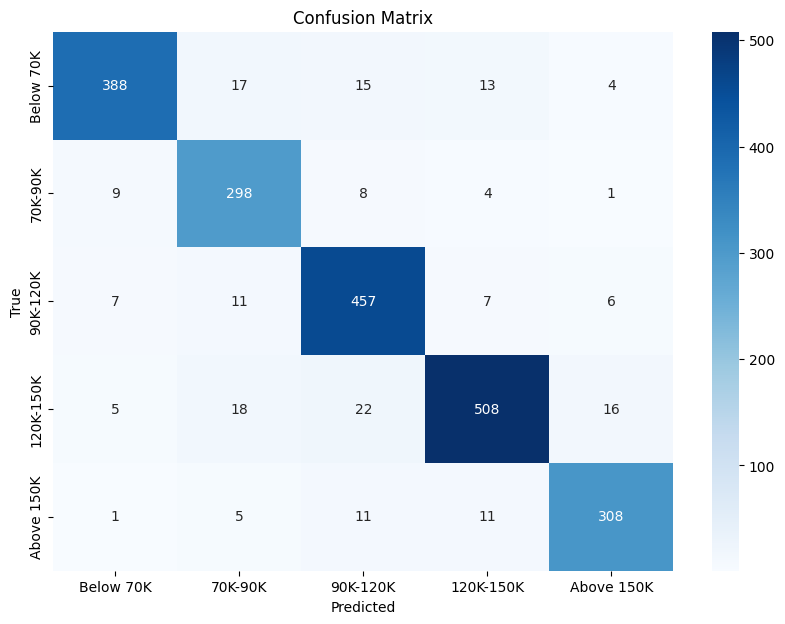

In [58]:
# Define the custom labels
labels = ["Below 70K", "70K-90K", "90K-120K", "120K-150K", "Above 150K"]

# Plotting
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [38]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score


In [59]:
# Calculate precision, recall, and F1-score for the training data predictions
accuracy = accuracy_score(y_train, predicted_classes_train)
precision = precision_score(y_train, predicted_classes_train, average='weighted')
recall = recall_score(y_train, predicted_classes_train, average='weighted')
f1 = f1_score(y_train, predicted_classes_train, average='weighted')

accuracy,precision, recall, f1


(0.9111627906976745,
 0.9129123790285352,
 0.9111627906976745,
 0.9113366041825565)

To see the probabilities:

In [40]:
probs = tf.nn.softmax(predicted_salary).numpy()

In [41]:
probs

array([[7.4198670e-03, 9.0767783e-01, 6.7254907e-05, 8.4625237e-02,
        2.0986328e-04],
       [2.5631575e-04, 2.0077505e-07, 8.5250298e-03, 9.0102911e-01,
        9.0189308e-02],
       [2.6312800e-02, 9.7165495e-01, 1.7982518e-03, 2.3240600e-04,
        1.6290493e-06],
       ...,
       [9.9995565e-01, 1.4770790e-06, 2.2081462e-05, 2.0775844e-05,
        4.4967922e-11],
       [3.2212727e-02, 8.9260298e-01, 1.3439320e-03, 7.2681095e-04,
        7.3113419e-02],
       [4.1195261e-03, 9.8772508e-01, 8.0606877e-04, 5.7564559e-03,
        1.5928086e-03]], dtype=float32)

To select the most likely category, the softmax is not required. One can find the index of the largest output using np.argmax().

In [42]:
for i in range(5):
    print( f"{predicted_salary[i]}, category: {np.argmax(predicted_salary[i])}")

[-4.015153    0.79157543 -8.718579   -1.5810816  -7.580613  ], category: 1
[ -4.5893335 -11.741314   -1.0849814   3.5755494   1.2739228], category: 3
[ 0.74122316  4.350168   -1.9420178  -3.988102   -8.948591  ], category: 1
[ -4.683672   -2.5565267   4.025982   -5.201401  -14.425289 ], category: 2
[-16.034403  -12.996643   10.087341   -5.970273   -3.6885312], category: 2


In [43]:
for i in range(5):
    print( f"{probs[i]}, category: {np.argmax(predicted_salary[i])}")

[7.4198670e-03 9.0767783e-01 6.7254907e-05 8.4625237e-02 2.0986328e-04], category: 1
[2.5631575e-04 2.0077505e-07 8.5250298e-03 9.0102911e-01 9.0189308e-02], category: 3
[2.6312800e-02 9.7165495e-01 1.7982518e-03 2.3240600e-04 1.6290493e-06], category: 1
[1.6471397e-04 1.3820948e-03 9.9835497e-01 9.8148485e-05 9.6827755e-09], category: 2
[4.5234541e-12 9.4352290e-11 9.9999881e-01 1.0623475e-07 1.0404332e-06], category: 2


Train Data:

In [44]:
predicted_salary_test = model.predict(X_test)

17/17 [==============================] - 0s 2ms/step


In [45]:
#Saving the choosen categories:
predicted_classes_test = np.argmax(predicted_salary_test, axis=1)

In [46]:
cm_test = confusion_matrix(y_test, predicted_classes_test)
cm_test

array([[26, 12, 36, 29,  9],
       [26, 30, 24,  6,  3],
       [19, 17, 38, 25, 29],
       [20, 10, 29, 49, 27],
       [ 3,  1, 22, 21, 27]], dtype=int64)

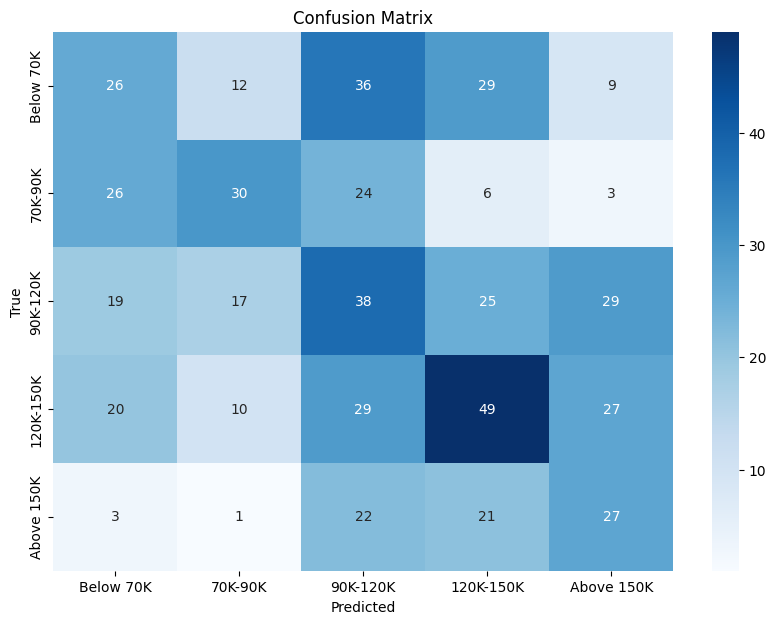

In [47]:
# Define the custom labels
labels = ["Below 70K", "70K-90K", "90K-120K", "120K-150K", "Above 150K"]

# Plotting
plt.figure(figsize=(10, 7))
sns.heatmap(cm_test, annot=True, fmt='g', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [48]:
# Compute and display accuracy
accuracy_test = accuracy_score(y_test, predicted_classes_test)
accuracy_test

0.3159851301115242

In [49]:
filename = "/mnt/data/my_data.csv"
df.to_csv(filename, index=False)

# Create a clickable link to download
link = f'<a href="{filename}" target="_blank">Click here to download the CSV file</a>'
display(HTML(link))

NameError: name 'df' is not defined

In [ ]:
jobs.to_csv('jobs.csv', index=False)


In [ ]:
jobs.drop(columns=['...1', 'index'],inplace=True)

In [2]:
print("Hamming Loss for ACT_English_benchmark:   0.10869565217391304")
print("Hamming Loss for ACT_Math_benchmark:      0.07434782608695657")
print("Hamming Loss for ACT_Reading_benchmark:   0.08978260869565214")

Hamming Loss for ACT_English_benchmark: 0.10869565217391304
Hamming Loss for ACT_English_benchmark: 0.10869565217391304
